# 

## Prop. fixation (risky, left, chosen) vs. Fixation number...
Use eyepos & not saccades

In [1]:
#from riskeye.utils.data import get_all_behavior, get_all_eyepos_info, get_all_subjects, Subject
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as op

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
plot_folder = op.join(bids_folder, 'plots_and_ims', 'eyetracking')


In [65]:
from utils import get_behavior, get_data
df_behav = get_data()
df = df_behav.xs(1,0,'session').xs('non-symbolic',0,'format')
df.index.names = ['subject','trial']

group_list = pd.DataFrame(df.groupby('subject').mean()['group'])

df['n_right'] = df['n1']
df['n_left'] = df['n2']
df['p_right'] = df['prob1']
df['p_left'] = df['prob2']


number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_31917/1801597689.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_list = pd.DataFrame(df.groupby('subject').mean()['group'])


In [66]:
def merge_fixations(d):
    d['previous_fixation_target'] = d['fixation_target'].shift(1)

    result = []

    n = 1
    duration = 0.0

    for ix, row in d.iterrows():
        if (row.fixation_target == row['previous_fixation_target']) or (pd.isnull(row.previous_fixation_target)):
            duration += row.duration
        else:
            result.append({'duration':duration, 'fixation_target':row.previous_fixation_target})
            duration = row.duration
            n += 1

    if duration != 0:
        result.append({'duration':duration, 'fixation_target':row.fixation_target})

    return pd.DataFrame(result, index=pd.Index(np.arange(1, n+1), name='n'))

In [67]:
from utils_eyetrack import get_all_eyepos_info
fixations = get_all_eyepos_info(source='eyepos', summarize=False)

fixations = fixations[fixations.index.get_level_values('trial') != 999] # remove trial 0, which is not a real trial


In [68]:
fixations = fixations[np.in1d(fixations['fixation_target'], ['left_option', 'right_option'])]#.droplevel('n')
fixations = fixations.groupby(['subject', 'trial']).apply(merge_fixations)

In [69]:
fixations = fixations.reset_index()
fixations['subject'] = fixations['subject'].astype(int)

fixations = fixations.set_index(['subject','trial','n'])
fixations

duration fixation_target
subject trial n                          
1       1     1     646.0     left_option
              2     666.0    right_option
              3     740.0     left_option
              4     486.0    right_option
        2     1     280.0     left_option
...                   ...             ...
66      191   3      70.0     left_option
        192   1     320.0     left_option
              2     364.0    right_option
              3     216.0     left_option
              4     154.0    right_option

[32578 rows x 2 columns]

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_31917/2428072067.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df_t_last.groupby('subject').mean()


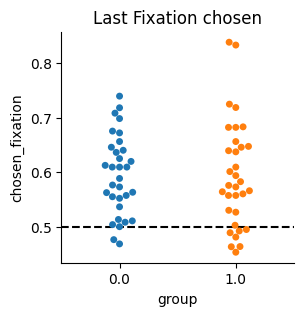

In [70]:
# see if subjetcs chose last fixation based on side-definition !

df_t = fixations.join(df)

df_t['chose_left'] = df_t['chose_left'].astype(bool)
df_t['chosen_fixation'] = (
    (df_t['chose_left'] & (df_t['fixation_target'] == 'left_option')) |
    ((~df_t['chose_left']) & (df_t['fixation_target'] == 'right_option'))
    )

df_t_last = df_t.groupby(['subject', 'trial']).apply(lambda d: d.reset_index('n').iloc[-1]) # take last ?

tmp = df_t_last.groupby('subject').mean()

fig, ax = plt.subplots(1,1,figsize=(3,3))
sns.swarmplot(tmp, x = 'group',hue='group', y='chosen_fixation',ax = ax,legend=False)
ax.set_title('Last Fixation chosen')
ax.axhline(0.5, c='black', ls='--')
sns.despine()

In [71]:
df_comb = fixations.join(df)#[['EV_left', 'EV_right', 'n_safe', 'n_risky', 'n_left', 'n_right', 'chose_risky', 'log(risky/safe)','group']])
df_comb['risk_left'] = (df_comb['p_left'] == 0.55)
print(df_comb.columns)

df_comb['risky_left'] = df_comb['risky_left'].astype(bool)
df_comb['chose_risky'] = df_comb['chose_risky'].astype(bool)

df_comb['risky_fixation'] = ((df_comb['fixation_target'] == 'left_option') & df_comb['risky_left']) | ((df_comb['fixation_target'] == 'right_option') & ~df_comb['risky_left'])
df_comb['left_fixation'] = (df_comb['fixation_target'] == 'left_option')

df_comb['safe_fixation'] = ~df_comb['risky_fixation'] 
df_comb['chosen_fixation'] = (df_comb['chose_risky']  & df_comb['risky_fixation']) | (~df_comb['chose_risky'] & df_comb['safe_fixation'])

Index(['duration', 'fixation_target', 'choice', 'n1', 'n2', 'prob1', 'prob2',
       'risky_left', 'chose_left', 'chose_risky', 'n_risky', 'n_safe', 'frac',
       'log(risky/safe)', 'log(n1)', 'bin(risky/safe)', 'p1', 'p2', 'group',
       'n_right', 'n_left', 'p_right', 'p_left', 'risk_left'],
      dtype='object')


In [73]:
last_fixations = df_comb.groupby(['subject', 'trial']).apply(lambda d: d.reset_index('n').iloc[-1]) # take last ?
last_fixations['n'] = 'last'
last_fixations.set_index('n', append=True, inplace=True)

In [57]:
sub = 6
last_fixations.loc[sub,10,:][['chosen_fixation', 'fixation_target', 'risky_left', 'chose_risky','chose_left']]

,chosen_fixation,fixation_target,risky_left,chose_risky,chose_left
n,,,,,
last,False,left_option,True,False,False


In [58]:
df_t_last.loc[sub,10][['chosen_fixation', 'fixation_target', 'risky_left', 'chose_risky','chose_left']]

chosen_fixation           True
fixation_target    left_option
risky_left                True
chose_risky              False
chose_left               False
Name: (6, 10), dtype: object

In [64]:
# compare last_fixations with df_t_last
trial = 12

for sub in range(1, 10):
    print(f"Subject {sub}, Trial {trial}")
    print(last_fixations.loc[sub,trial][['chosen_fixation']].values)
    print(df_t_last.loc[sub,trial][['chosen_fixation']].values)

# for most same, but e.g. sub-3, sub-6,sub-7 not (trial 10)
# --> changes over trials over subs (no singel sub outliers)

Subject 1, Trial 12
[[ True]]
[True]
Subject 2, Trial 12
[[ True]]
[True]
Subject 3, Trial 12
[[ True]]
[True]
Subject 4, Trial 12
[[ True]]
[True]
Subject 5, Trial 12
[[False]]
[False]
Subject 6, Trial 12
[[False]]
[False]
Subject 7, Trial 12
[[ True]]
[True]
Subject 8, Trial 12
[[ True]]
[True]
Subject 9, Trial 12
[[False]]
[False]


/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_31917/2198737107.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = last_fixations.groupby('subject').mean()


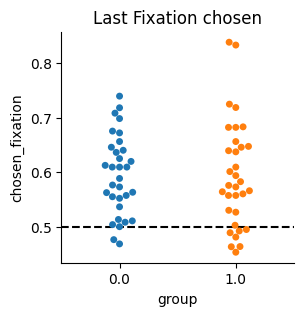

In [74]:
tmp = last_fixations.groupby('subject').mean()

fig, ax = plt.subplots(1,1,figsize=(3,3))
sns.swarmplot(tmp, x = 'group',hue='group', y='chosen_fixation',ax = ax,legend=False)
ax.set_title('Last Fixation chosen')
ax.axhline(0.5, c='black', ls='--')
sns.despine()

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_31917/1033580389.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df_comb.groupby(['subject', 'n']).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_31917/1033580389.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['subject',  'n']).mean()))


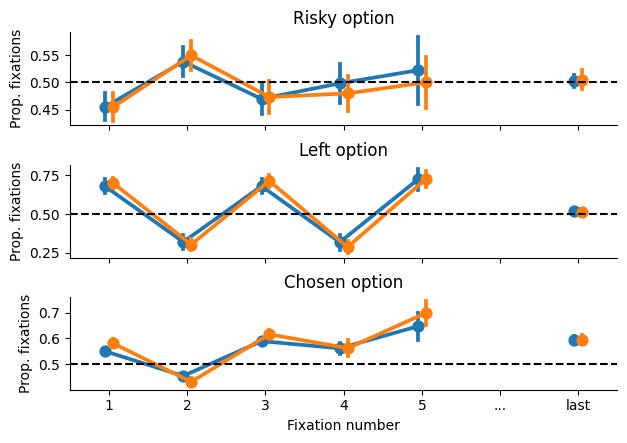

In [76]:
tmp = df_comb.groupby(['subject', 'n']).mean()
tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['subject',  'n']).mean()))

tmp.columns.name = 'fixation'
tmp = tmp[['risky_fixation', 'left_fixation', 'chosen_fixation','group']].stack().to_frame('value').reset_index()

tmp['fixation'] = tmp['fixation'].map({'risky_fixation':'Risky option', 'left_fixation':'Left option', 'chosen_fixation':'Chosen option'})

tmp['subject'] = tmp['subject'].astype(int)
tmp = tmp.set_index('subject').join(group_list)

g = sns.catplot(data=tmp.reset_index(), x='n', y='value', row='fixation', hue='group', 
                kind='point', errorbar='se', order=[1, 2, 3, 4, 5,  '...', 'last'], 
                 aspect=4.25, height=1.5, sharey=False, legend=False, dodge=.1)

g.set(xlabel='Fixation number', ylabel='Prop. fixations')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
g.set_titles('{row_name}', size=12)

plt.show()
#g.savefig(op.join(plot_folder, 'fixations_of_n.pdf'))

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.loc[sub].groupby(['trial', 'n']).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['trial',  'n']).mean()))


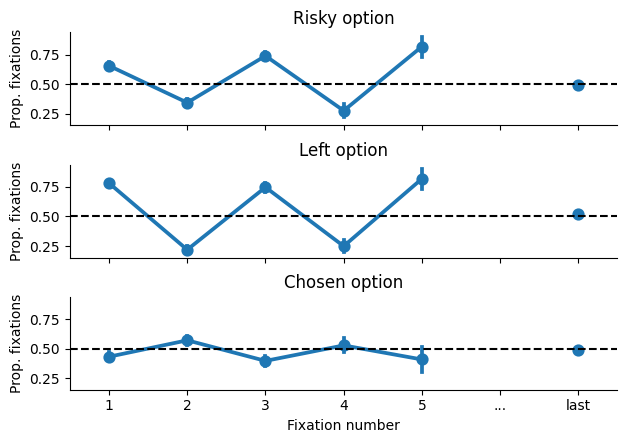

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.loc[sub].groupby(['trial', 'n']).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['trial',  'n']).mean()))


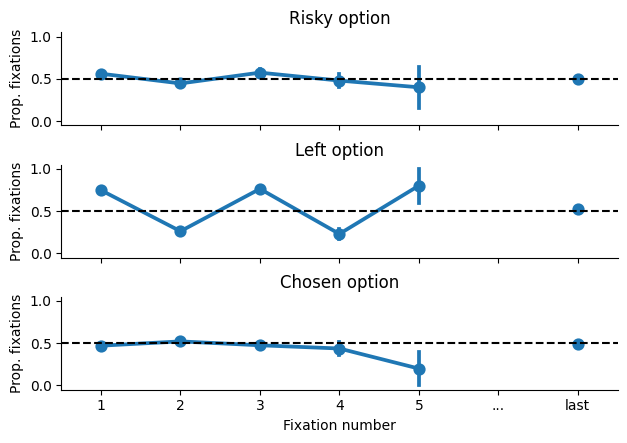

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.loc[sub].groupby(['trial', 'n']).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['trial',  'n']).mean()))


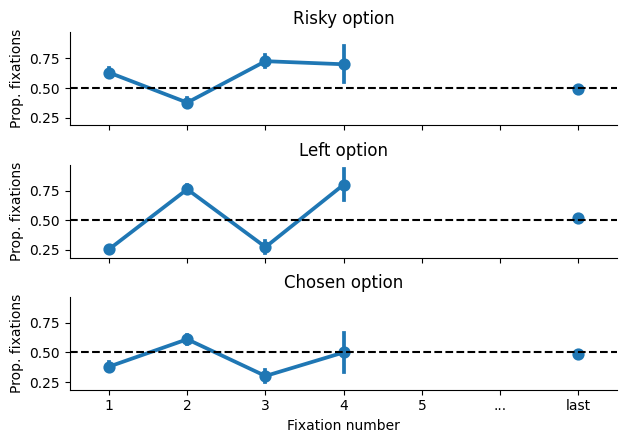

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.loc[sub].groupby(['trial', 'n']).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['trial',  'n']).mean()))


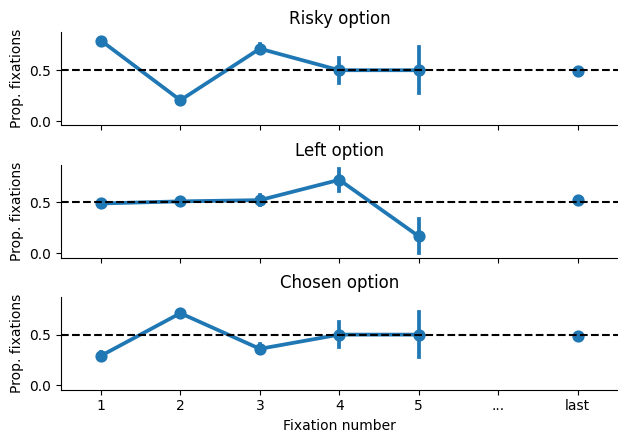

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.loc[sub].groupby(['trial', 'n']).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['trial',  'n']).mean()))


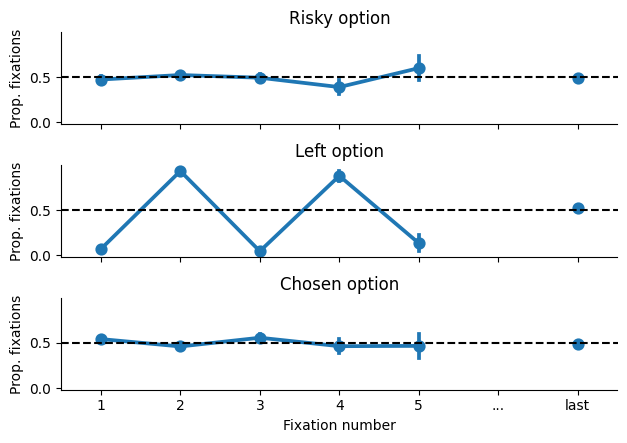

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.loc[sub].groupby(['trial', 'n']).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['trial',  'n']).mean()))


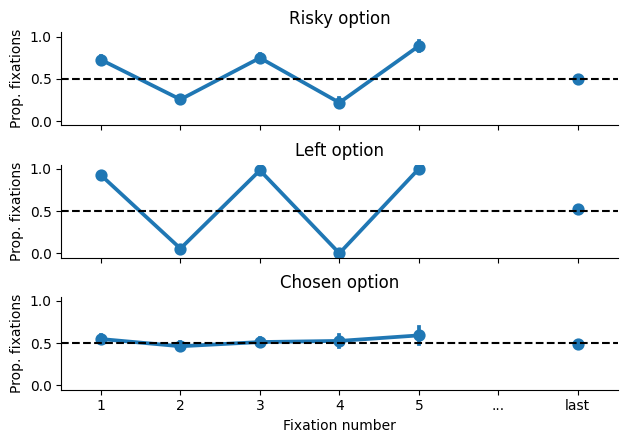

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.loc[sub].groupby(['trial', 'n']).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['trial',  'n']).mean()))


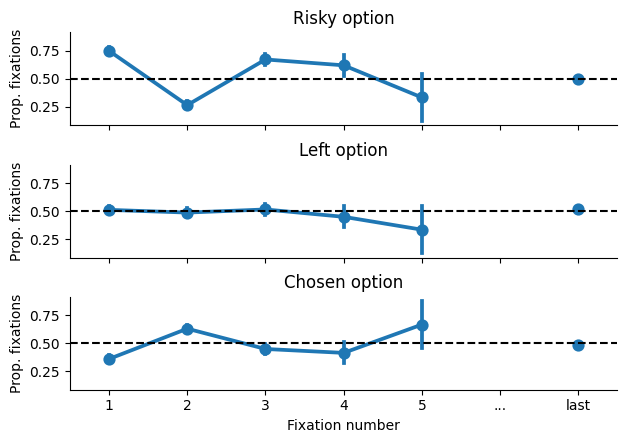

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.loc[sub].groupby(['trial', 'n']).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['trial',  'n']).mean()))


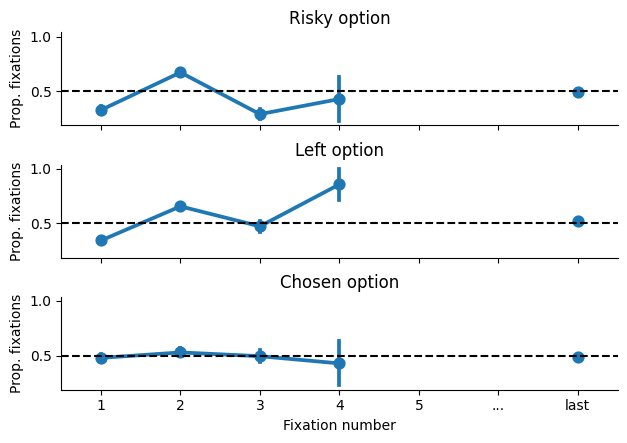

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = fixations.loc[sub].groupby(['trial', 'n']).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_91326/3326248050.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['trial',  'n']).mean()))


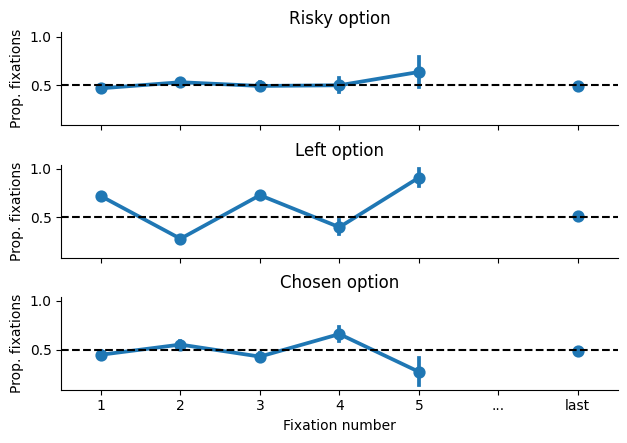

In [112]:
#fixations.loc[1].groupby(['trial', 'n']).mean()
for sub in range(1,10):
    tmp = fixations.loc[sub].groupby(['trial', 'n']).mean()

    tmp = pd.concat((tmp.query('n < 6'), last_fixations.groupby(['trial',  'n']).mean()))

    tmp.columns.name = 'fixation'
    tmp = tmp[['risky_fixation', 'left_fixation', 'chosen_fixation','group']].stack().to_frame('value').reset_index()

    tmp['fixation'] = tmp['fixation'].map({'risky_fixation':'Risky option', 'left_fixation':'Left option', 'chosen_fixation':'Chosen option'})

    g = sns.catplot(data=tmp, x='n', y='value', row='fixation', 
                    kind='point', errorbar='se', order=[1, 2, 3, 4, 5,  '...', 'last'], 
                    aspect=4.25, height=1.5, sharey=True, legend=False) #, dodge=.1)

    g.set(xlabel='Fixation number', ylabel='Prop. fixations')
    g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
    g.set_titles('{row_name}', size=12)

    plt.show()

In [ ]:
# try only with singel subjects to see if there are some that behave accordingly!?



In [93]:
tmp.loc[1]

,n,fixation,value,group
subject,,,,
1,1,Risky option,0.656250,0.0
1,1,Left option,0.781250,0.0
1,1,Chosen option,0.432292,0.0
1,1,NaN,0.000000,0.0
1,2,Risky option,0.345550,0.0
1,2,Left option,0.219895,0.0
1,2,Chosen option,0.570681,0.0
1,2,NaN,0.000000,0.0
1,3,Risky option,0.739726,0.0
